## Week 8 Optional Programming

(Optional Programming Exercises)

    Download and experiment with the sparse modeling free software packages linked in the class website.
    Compare the results of sparse modeling image denoising with those of DCT-based image denoising as implemented in ipol.im
    Consider an image and select K patches from it as the dictionary; select those patches at random. With this dictionary perform sparse modeling image denoising and compare with the results obtained when learning the dictionary.
    Pick a particular example of sparse modeling image denoising and experiment with different dictionary sizes. Plot the histogram of atoms usage, meaning the number of times each atom is used considering all image patches.
    
http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf
    
http://spams-devel.gforge.inria.fr/

http://spams-devel.gforge.inria.fr/doc-python/html/index.html

In [1]:
from __future__ import division, print_function

import spams
import numpy as np
import time
from PIL import Image

from matplotlib import pyplot as plt
import time

from skimage import img_as_float
from skimage import io
from skimage.color import rgb2gray
from skimage.util import random_noise
%matplotlib inline

# Plotting stuff

def plot_1xc(imgs_list, titles_list, save_file=None):
    cols = len(imgs_list)
    i = 0
    
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,15))
    for c in range(cols):
        axes[c].imshow(imgs_list[i], cmap="gray", interpolation="nearest")
        axes[c].set_title(titles_list[i], size=20)
        axes[c].set_xticks([])
        axes[c].set_yticks([])
        i = i + 1
    plt.tight_layout();
    
    if not (save_file == None):
        filename = time.strftime("%Y%m%d_%H%M") + "_" + save_file + ".png"
        fig.savefig(filename, bbox_inches='tight')
        
def plot_rxc(imgs_list, titles_list, ncol=3, save_file=None):
    cols = ncol
    rows = np.ceil(len(imgs_list)/cols).astype(int)
    if rows==1:
        plot_1xc(imgs_list, titles_list, save_file)
    else:
        i = 0
    
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15*rows/cols))
        for r in range(rows):
            for c in range(cols):
                if i < len(imgs_list):
                    axes[r,c].imshow(imgs_list[i], cmap="gray", interpolation="nearest")
                    axes[r,c].set_title(titles_list[i], size=20)
                    axes[r,c].set_xticks([])
                    axes[r,c].set_yticks([])
                i = i + 1
        plt.tight_layout();
    
        if not (save_file == None):
            filename = time.strftime("%Y%m%d_%H%M") + "_" + save_file + ".png"
            fig.savefig(filename, bbox_inches='tight')

In [2]:
def get_patch_origin_indices(target_indices, offset_r, offset_c):
    return (target_indices[0]-offset_c, target_indices[1]-offset_r)

def get_patch_as_column(origin_indices, column_matrix, image_height, n):
    column_matrix_index = origin_indices[0] + origin_indices[1]*(image_height-n+1)
    return column_matrix[:, column_matrix_index]

def get_target_from_column(patch_column, offset_r, offset_c, n):
    return patch_column[offset_c + offset_r*n]

In [3]:
def get_random_patch(im_collection, size=512):
    r = np.random.randint(len(im_collection))
    img = im_collection[r]
    img = img_as_float(rgb2gray(img))
    
    if (img.shape[0]==size) & (img.shape[1]==size):
        patch = img
    else:
        x_offset_max = img.shape[0] - size
        y_offset_max = img.shape[1] - size
        x_offset = np.random.randint(x_offset_max)
        y_offset = np.random.randint(y_offset_max)
        patch = img[x_offset:(x_offset+size), y_offset:(y_offset+size)]
        
    flip = np.random.rand()
    if flip > 0.5:
        patch = patch[:, ::-1]

    return patch

In [4]:
def construct_dictionary(im_collection, img_size, dict_size, D = None, iters=10):
    m = 8; n = 8; rgb = False
    
    
    for i in range(iters):    
        if not i % 50:
            print(str(i) + "/" + str(iters))
        I = get_random_patch(im_collection, size=img_size)
        A = np.asfortranarray(I)
        X = spams.im2col_sliding(A,m,n,rgb)
        X = np.asfortranarray(X)

        param = { 'K' : dict_size, 'lambda1' : 0.15, 'numThreads' : 4, 
                 'batchsize' : 400, 'iter' : 10}

        if D == None:
            D = spams.trainDL(X, **param)
        else:
            D = spams.trainDL(X, D=D, **param)

    return D

def reconstruct_image(I_noisy, D, num_features):
    rgb = False
    m = 8;n = 8;

    A = np.asfortranarray(I_noisy)
    X = spams.im2col_sliding(A,m,n,rgb)

    X = np.asfortranarray(X)

    # Get our alphas for each patch
    alphas = spams.omp(X, D, L=num_features)
    D_alphas = D * alphas

    I_new = np.zeros_like(I_noisy)

    for r in range(n, I.shape[0]-n-1):
        for c in range(m, I.shape[1]-m-1):
            contributing_pixels = np.zeros(m*n)
            pix_num = 0
            for offset_r in range(n):
                for offset_c in range(m):                
                    target_indices = (r,c)
                    origin_indices = get_patch_origin_indices(target_indices, offset_r, offset_c)
                    patch_column = get_patch_as_column(origin_indices, D_alphas, I.shape[1], n)
                    target_from_patch = get_target_from_column(patch_column, offset_r, offset_c, n)
                    contributing_pixels[pix_num] = target_from_patch
                    pix_num += 1
            I_new[r,c] = np.mean(contributing_pixels)
    
    return(I_new)


In [5]:
img_file = '../images/boat.png'
img = Image.open(img_file)
I = np.array(img) / 255.
I_noisy = random_noise(I, mode='gaussian', var=0.005)

# im_collection = io.imread_collection("../images/ships/*.jpg")
im_collection = io.imread_collection("../images/graphics/*.jpg")

dict_size = 500
iters1 = 1000
D = construct_dictionary(im_collection, I.shape[0], dict_size=dict_size, iters=iters1)

iters2 = 25
im_collection = io.imread_collection("../images/bo*.png")
D = construct_dictionary(im_collection, I.shape[0], dict_size=dict_size, D=D, iters=iters2)



0/1000
50/1000
100/1000
150/1000
200/1000
250/1000
300/1000
350/1000
400/1000
450/1000
500/1000
550/1000
600/1000
650/1000
700/1000
750/1000
800/1000
850/1000
900/1000
950/1000
0/25


/home/robert/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/robert/anaconda2/lib/python2.7/site-packages/spams.py:1783: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if D == None:


1
2
3
4


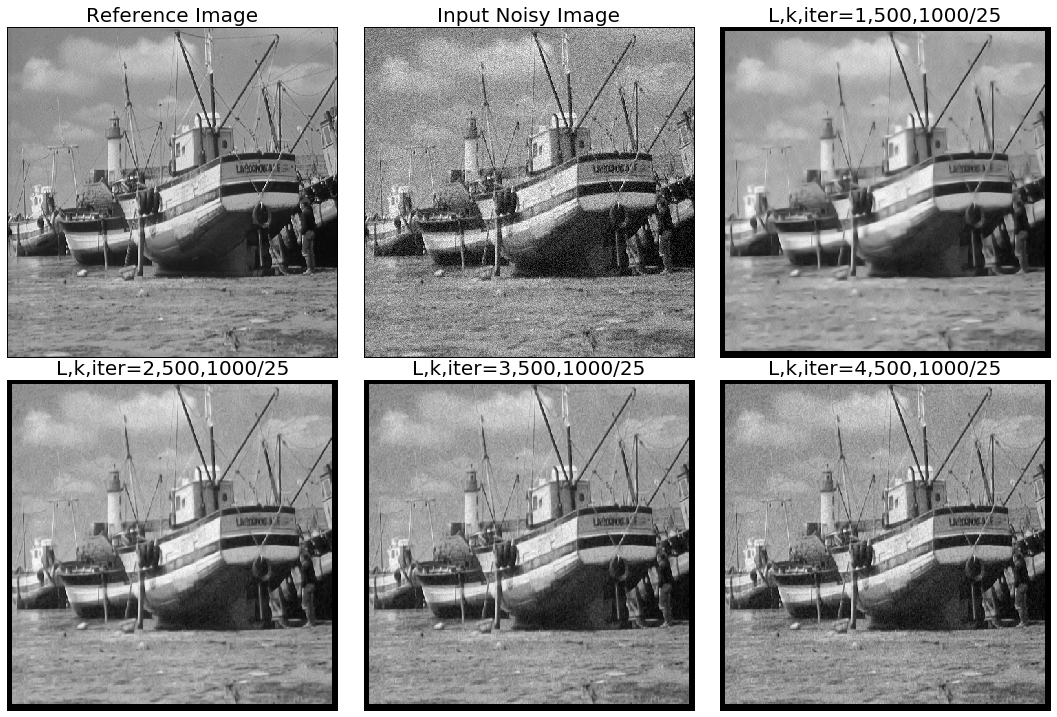

In [6]:
ims = []
ims.append(I)
ims.append(I_noisy)
titles = []
titles.append("Reference Image")
titles.append("Input Noisy Image")

for f in range(1,5):
    print(f)
    I_reconstructed = reconstruct_image(I_noisy, D, num_features=f)

    ims.append(I_reconstructed.copy())
    s = "L,k,iter=" + str(f) + ","
    s = s + str(dict_size) + ","
    s = s + str(iters1) + "/" + str(iters2)
    titles.append(s)

plot_rxc(ims, titles, ncol=3, save_file="denoising_2")